In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from d2l import torch as d2l
import utils
import math

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

## Text data

In [3]:
import os
import requests

# Generated by ChatGPT
# 1. 下载文本数据
def download_time_machine():
    url = "http://www.gutenberg.org/files/35/35-0.txt"
    filename = "./data/timemachine.txt"
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        with open(filename, "w", encoding="utf-8") as f:
            f.write(response.text)
    else:
        print(f"{filename} already exists.")
    return filename

# 2. 定义词汇表类
class Vocab:
    def __init__(self, tokens, min_freq=0, reserved_tokens=None):
        # 统计词频
        counter = {}
        for token in tokens:
            counter[token] = counter.get(token, 0) + 1
        # 保留的特殊符号
        self.reserved_tokens = reserved_tokens if reserved_tokens else ['<unk>']
        # 排序词表
        self.token_freqs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
        # 构建词表
        self.idx_to_token = self.reserved_tokens + [token for token, freq in self.token_freqs if freq >= min_freq]
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            # 返回 '<unk>' 索引，如果找不到该 token
            return self.token_to_idx.get(tokens, self.token_to_idx['<unk>'])
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

# 3. 加载文本数据
def load_time_machine():
    filename = download_time_machine()
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    # 处理文本：小写化并去除无效行
    return [line.strip().lower().replace('\n', '') for line in lines if len(line.strip()) > 0]

# 4. 转换为字符级数据
def tokenize(lines, token='char'):
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]

# 5. 构建小批量数据集
class SeqDataset(Dataset):
    def __init__(self, corpus_indices, seq_length):
        self.corpus_indices = corpus_indices
        self.seq_length = seq_length

    def __len__(self):
        return (len(self.corpus_indices) - 1) // self.seq_length

    def __getitem__(self, idx):
        start = idx * self.seq_length
        end = start + self.seq_length + 1
        seq = self.corpus_indices[start:end]
        return (torch.tensor(seq[:-1], dtype=torch.long), torch.tensor(seq[1:], dtype=torch.long))

def load_data_time_machine(batch_size, num_steps):
    # 读取和预处理文本数据
    lines = load_time_machine()
    tokens = tokenize(lines, token='char')
    # 构建词汇表
    vocab = Vocab([token for line in tokens for token in line])
    # 转换为索引
    corpus_indices = [vocab[token] for line in tokens for token in line]
    # 构建数据集
    dataset = SeqDataset(corpus_indices, num_steps)
    # 构建数据加载器
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_iter, vocab

In [4]:
batch_size, num_steps = 32, 35
data_iter, vocab = load_data_time_machine(batch_size, num_steps)

./data/timemachine.txt already exists.


## RNN in Torch

In [5]:
num_hiddens = 256
# len(vocab) is the dimension, think of the one-hot encoding
rnn_layer = nn.RNN(len(vocab), num_hiddens)
# parametric initialization setting
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

In [6]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
# Y is the hidden state of each time step
Y, state_new = rnn_layer(X, state)
X.shape, Y.shape, state_new.shape

(torch.Size([35, 32, 68]), torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [7]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.batch_size = None
        # RNN can be bidirectional
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.num_hiddens * 2, self.vocab_size)

    def forward(self, inputs, state):
        # transpose the last two dimensions
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        # Y: (num_steps, batch_size, hidden_size)
        Y, state = self.rnn(X, state)
        # fully connected layer
        output = self.linear(Y.reshape((-1, Y.shape[-1]))) # Y: (num_steps * batch_size, vocab_size)
        return output, state

    def begin_state(self, device, batch_size=1):
        self.batch_size = batch_size
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros(
                (self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), 
                device=device)
        else:
            state_0 = torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
            state_1 = torch.zeros((self.num_directions * self.rnn.num_layers, batch_size, self.num_hiddens), device=device)
            return (state_0, state_1)

In [8]:
def predict(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1)) # ? minus 1?
    for y in prefix[1:]:
        # combine the input and hidden state
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        # return: predicted vector, hidden state
        y, state = net(get_input(), state) 
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    
    return ''.join([vocab.idx_to_token[i] for i in outputs])

def grad_clipping(net, theta):
    '''
    clip the gradient to stablize the training
    '''
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    '''
    training a iteration
    '''
    state, timer = None, utils.Timer()
    metric = utils.Accumulator(2) # loss_sum, num_tokens
    for X, Y in train_iter:
        # Y is the 1-step lagged tensor of the X, for the prediction
        if state is None or use_random_iter:
            batch_size = len(X)
            state = net.begin_state(batch_size=batch_size, device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_() # what does it means?
                if (batch_size := len(X)) < state.shape[-2]:
                    # slice the state tensor to match the batch size at the reversed second dimension
                    state = state[..., :batch_size, :]
            else:
                state = list(state)
                for i, s in enumerate(state):
                    s.detach_()
                    if (batch_size := len(X)) < s.shape[-2]:
                        state[i] = s[..., :batch_size, :]
                state = tuple(state)
        y = Y.T.reshape(-1) 
        X, y = X.to(device), y.to(device)
        
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

def train(net, train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = utils.Animator(xlabel='epoch', ylabel='perplexity', 
                              legend=['train'], xlim=[10, num_epochs])
    # initialize the model parameters
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict_wrap = lambda prefix: predict(prefix, 50, net, vocab, device)
    # training and prediction
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict_wrap('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'perplexity {ppl:.1f}, {speed:.1f} tokens/sec on {str(device)}')
    print(predict_wrap('time traveller'))
    print(predict_wrap('traveller'))

In [9]:
device = utils.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict('time traveller', 10, net, vocab, device)

'time traveller:$:%e:%e:%'

perplexity 4.3, 406228.8 tokens/sec on cuda:0
time traveller and went of my fire, with a stared at least a cou
traveller met the same a notice of seemed to me, we were se


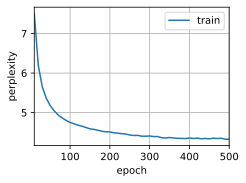

In [10]:
num_epochs, lr = 500, 1
train(net, data_iter, vocab, lr, num_epochs, device)

## RNN in Scratch

In [9]:
F.one_hot(torch.tensor([0, 6]), 10)

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [10]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, len(vocab)).shape

torch.Size([5, 2, 68])

In [11]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xh, W_hh, b_h = three() # hidde units initialization

    # output layer
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # additional gradients
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    output = []
    # X shape: (batchsize, embedding_dim)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        output.append(Y)
    return torch.cat(output, dim=0), (H,)

In [12]:
class RNNScratch:
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        # turn the first dimension as the timestep
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        # arrange of the rnn, each sequence has different iteration state
        return self.init_state(batch_size, self.num_hiddens, device)

num_hiddens = 512
net = RNNScratch(len(vocab), num_hiddens, utils.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], utils.try_gpu())
Y, new_state = net(X.to(utils.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 68]), 1, torch.Size([2, 512]))

perplexity 4.3, 424671.9 tokens/sec on cuda:0
time traveller put the morlocks, and the morlocks, and the morlo
traveller put the morlocks, and the morlocks, and the morlo


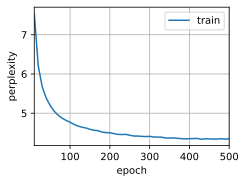

In [64]:
# warming and training
predict('time traveller', 10, net, vocab, device)

num_epochs, lr = 500, 1
train(net, data_iter, vocab, lr, num_epochs, device)

## LSTM

### In Scratch

In [27]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three() # input gate
    W_xf, W_hf, b_f = three() # forget gate
    W_xo, W_ho, b_o = three() # output gate
    W_xc, W_hc, b_c = three() # candidate memory cell

    # output layer
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # additional gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, 
                W_xc, W_hc, b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

def lstm(inputs, state, params):
    '''
    inputs: (num_steps, batch_size, vocab_size)
    state: (h, c)
    '''
    W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c, W_hq, b_q = params
    # H and C is STM and LTM respectively
    H, C = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = H @ W_hq + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

perplexity 2.4, 15237.4 tokens/sec on cuda:0
time traveller and slower went the class the methadtle of the mo
traveller and the shaup of energys and compoiental large as


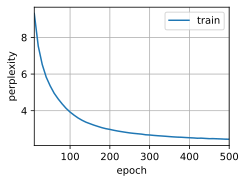

In [28]:
vocab_size, num_hiddens, device = len(vocab), 256, utils.try_gpu()
num_epochs, lr = 500, 1
model = RNNScratch(len(vocab), num_hiddens, device, get_lstm_params, init_lstm_state, lstm)
train(model, data_iter, vocab, lr, num_epochs, device)

### In Torch

In [ ]:
lstm_layer = nn.LSTM(num_hiddens)
model = RNNModel(lstm_layer, len(vocab))
train(model, data_iter, vocab, lr, num_epochs, device)

## GRU

In [ ]:
num_inputs = vocab_size
gru_layer = nn.GRU(num_inputs, num_hiddens)
model = RNNModel(gru_layer, len(vocab))
model = model.to(device)
train(model, data_iter, vocab, lr, num_epochs, device)

## Deep RNN

In [ ]:
vocab_size, num_hiddens, num_layers = len(vocab), 256, 2
num_inputs = vocab_size
device = utils.try_gpu()
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

In [ ]:
num_epochs, lr = 500, 2
train(model, data_iter, vocab, lr, num_epochs, device)

## Bi-directional RNN

In [ ]:
lstm_layer = nn.LSTM(num_inputs, num_hiddens, num_layers, bidirectional=True)
model = RNNModel(lstm_layer, len(vocab))
model = model.to(device)

num_epochs, lr = 500, 1
train(model, data_iter, vocab, lr, num_epochs, device)